# NOTE

* Check you can login and see a workspace
* Find data using the web interface
* Use notebook to find data using pyeodh - everyone needs access to the AppHub
* Data visualisation - titiler and other (Daniel W helping)

# Pathfinder Phase Workshop: Finding Data

__Description & purpose__: This Notebook is designed to showcase the functionality of the Earth Observation Data Hub (EODH) as the project approaches the end of the Pathfinder Phase. It provides a snapshot of the Hub, the `pyeodh` API client and the various datasets as of February 2025.   

__Author(s)__: Alastair Graham, Dusan Figala

__Date created__: 2025-02-18

__Date last modified__: 2025-02-20

__Licence__: This notebook is licensed under [Creative Commons Attribution-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-sa/4.0/).  The code is released using the [BSD-2-Clause](https://www.tldrlegal.com/license/bsd-2-clause-license-freebsd) license.


<span style="font-size:0.75em;">
Copyright (c) , All rights reserved.</span>

<span style="font-size:0.75em;">
Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:</span>

<span style="font-size:0.75em;">
Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer. Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution. THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.</span>

# Visual data discovery

The first thing to do is find some data. Initially we will be using the current Catalogue User Interface (Note: a replacement user interface is in development, as demonstrated in the Workshop). There are two initial tasks that you will need to complete to find some data. First, using the tool shown in the image below on the right-hand side of the map pane, draw an area of interest (AOI) roughly in the region of Thetford. The Image shows an example of such an AOI as an orange outline. The other task is to navigate through the floating pane shown to the left in the image below to find `Supported Datasets > CEDA STAC API > Sentinel 2 ARD` 

![](images/07.png "Data Catalogue")

Once you have entered the `Sentinel 2 ARD` collection, you should see a list of images related to the AOI. Somewhere near the top of the list will be the image that we are looking for. It is shown as the third from top in the list in the image below. The item name will contain the following information, so look for this

* date:`2023-11-17`
* orbit: `ORB137`
* projection: `utm31n_osgb`
* location code: `T31UCU`

![](images/08.png "Data list")

Click on the relevant item to find the assets within it. There are a number of assets (data layers, metadata, thumbnail etc.) within the item. Take some time to investigate what exists. The two we are interested in here are `thumbnail` and `cog` (the cog holds the image data). The image below shows how to copy the URL to the COG data: either using the button on the left or copying the path in the text box on the right.

![](images/09.png "Asset information")

Check that you have found the datset we are interested in:

* Thumbnail: https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/11/17/S2A_20231117_latn527lone0008_T30UYD_ORB137_20231117131218_utm30n_osgb_vmsk_sharp_rad_srefdem_stdsref_thumbnail.jpg (you can open this in a web browser and it should look like the image below)
* Dataset: https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/11/17/S2A_20231117_latn527lone0008_T30UYD_ORB137_20231117131218_utm30n_osgb_vmsk_sharp_rad_srefdem_stdsref.tif

![](images/10.png "Item thumbnail")

Take some time to click around the listed datasets to see what is included and accessible. 

**Note** that **not all collections contain items**.

# Coded data discovery

There are a number of API endpoints that are exposed by the EODH. Oxidian have developed a Python API Client, `pyeodh`, that makes the Hub's API endpoints available to Python users. `pyeodh` is available on PyPi (https://pypi.org/project/pyeodh/) and can be installed using `pip`. Documentation for the API Client is available at: https://pyeodh.readthedocs.io/en/latest/api.html

We will use `pyeodh` throughout this workshop.

## Presentation set up

The following cell only needs to be run on the EODH AppHub.  If you have a local Python environment running, please install the required packages as you would normally e.g. using `mamba`, `poetry` etc.

In [ ]:
# If needed you can install a package in the current AppHub Jupyter environment using pip
# For instance, we will need at least the following libraries

import sys
!{sys.executable} -m pip install --upgrade pyeodh geopandas shapely matplotlib numpy pillow folium

In [ ]:
# Imports
import pyeodh

import shapely as sh 
import geopandas as gpd
import folium

import urllib.request

from PIL import Image
from io import BytesIO

Having imported the necessary libraries the next task is to set up the locations of the areas of interest.
Having created the AOI points the user needs to connect to the Resource Catalogue so that they can start to find some data.

In [10]:
# Areas of Interest
thet_pnt = sh.Point(0.6715892933273722, 52.414471075812315) # a site near Thetford

In [13]:
# Optional cell
# If you want to see these points on a map run this cell
# You may need to run the notebook through a service such as nbviewer: https://nbviewer.org/

# Create a map (m) centered on the point
center_lat = (thet_pnt.y)
center_lon = (thet_pnt.x)

m = folium.Map(location=[center_lat, center_lon], zoom_start=10)

# Add markers for the point
folium.Marker([thet_pnt.y, thet_pnt.x], popup="Thetford Site", icon=folium.Icon(color="green")).add_to(m)

# Step 4: Display the map
m

In [14]:
# Connect to the Hub
# base_url can be changed to optionally specify a different server, such as test.eodatahub

client = pyeodh.Client(
    base_url="https://staging.eodatahub.org.uk"
).get_catalog_service()

In [16]:
# Print a list of the collections held in the Resource Catalogue (their id and description).
# As the Resource Catalogue fills and development continues, the number of collections and the richness of their descriptions will increase

for index, collect in enumerate(client.get_collections(), start=1):
    print(f"{index} -- {collect.id}: {collect.description}")

1 -- ukcp: Regional climate model projections produced as part of the UK Climate Projection 2018 (UKCP18) project. The data produced by the Met Office Hadley Centre provides information on changes in climate for the UK until 2080, downscaled to a high resolution (12km), helping to inform adaptation to a changing climate. The projections cover Europe and a 100 year period, 1981-2080, for a high emissions scenario, RCP8.5. Each projection provides an example of climate variability in a changing climate, which is consistent across climate variables at different times and spatial locations. This dataset contains 12km data for the United Kingdom, the Isle of Man and the Channel Islands provided on the Ordnance Survey's British National Grid.
2 -- sentinel2_ard: These data have been created by the Department for Environment, Food and Rural Affairs (Defra) and Joint Nature Conservation Committee (JNCC) in order to cost-effectively provide high quality, Analysis Ready Data (ARD) for a wide ran

The dataset that we are interested in for the purposes of this workshop is `sentinel2_ard`. As seen from the output from the previous cell, we can see that the description of the dataset is as follows:

_These data have been created by the Department for Environment, Food and Rural Affairs (Defra) and Joint Nature Conservation Committee (JNCC) in order to cost-effectively provide high quality, Analysis Ready Data (ARD) for a wide range of applications. The dataset contains modified Copernicus Sentinel-2 (Level 1C data processed into a surface reflectance product using ARCSI software (Level 2))._

In [ ]:
# The next thing to do is find some open data
# For this workshop we want to find Sentinel-2 analysis ready (ARD) imagery near Thetford

# First we just want to understand the timespan of the dataset which is reported from the STAC collection record
sentinel2_ard = client.get_catalog("supported-datasets/catalogs/ceda-stac-catalogue").get_collection('sentinel2_ard')
sentinel2_ard.get_items()

print('DATASET TEMPORAL EXTENT: ', [str(d) for d in sentinel2_ard.extent.temporal.intervals[0]])

DATASET TEMPORAL EXTENT:  ['2023-01-01 11:14:51+00:00', '2023-11-01 11:43:49+00:00']


In [54]:
# Now we want to access the first few items and see what they are called, when the image was collected and how much cloud there is  

lim = 10

for i, item in enumerate(sentinel2_ard.get_items()):
    if i >= lim:
        break
    print(item.id, item.properties['datetime'], item.properties['eo:cloud_cover'])

neodc.sentinel_ard.data.sentinel_2.2023.11.21.S2B_20231121_latn536lonw0052_T30UUE_ORB123_20231121122846_utm30n_TM65 2023-11-21T11:43:49Z 67.568010963291
neodc.sentinel_ard.data.sentinel_2.2023.11.20.S2A_20231120_latn563lonw0037_T30VVH_ORB037_20231120132420_utm30n_osgb 2023-11-20T11:23:51Z 17.320411981252
neodc.sentinel_ard.data.sentinel_2.2023.11.20.S2A_20231120_latn546lonw0037_T30UVF_ORB037_20231120132420_utm30n_osgb 2023-11-20T11:23:51Z 37.725362031379
neodc.sentinel_ard.data.sentinel_2.2023.11.20.S2A_20231120_latn536lonw0007_T30UXE_ORB037_20231120132420_utm30n_osgb 2023-11-20T11:23:51Z 20.866700948979
neodc.sentinel_ard.data.sentinel_2.2023.11.20.S2A_20231120_latn528lonw0022_T30UWD_ORB037_20231120132420_utm30n_osgb 2023-11-20T11:23:51Z 44.517572934396
neodc.sentinel_ard.data.sentinel_2.2023.11.20.S2A_20231120_latn527lonw0007_T30UXD_ORB037_20231120132420_utm30n_osgb 2023-11-20T11:23:51Z 5.880352134231
neodc.sentinel_ard.data.sentinel_2.2023.11.20.S2A_20231120_latn519lonw0037_T30UVC_O

The previous cell shows us that we are able to access Sentinel 2 ARD data and find out a number of bits of information about the item. If you are interested in seeing what other information is accessible, have a look at the 

* collection endpoint: https://staging.eodatahub.org.uk/api/catalogue/stac/catalogs/supported-datasets/catalogs/ceda-stac-catalogue/collections/sentinel2_ard
* items endpoint: https://staging.eodatahub.org.uk/api/catalogue/stac/catalogs/supported-datasets/catalogs/ceda-stac-catalogue/collections/sentinel2_ard/items

In [ ]:
# To find out information about all the imagery in the collection then use this cell
# It undertakes a search for specific date ranges (November 2023) and limits the pagination return to 10
item_search = client.search(
    collections=['sentinel2_ard'],
    catalog_paths=["supported-datasets/catalogs/ceda-stac-catalogue"],
    query=[
        'start_datetime>=2023-11-01',
        'end_datetime<=2023-11-30', 
    ],
    limit=10,
)

# The item id and start time of image capture can be printed
# If end time is also required, add the following code to the print statement: item.properties["end_datetime"]  
for item in item_search:
    print(item.id)#, item.properties["start_datetime"])

neodc.sentinel_ard.data.sentinel_2.2023.11.21.S2B_20231121_latn536lonw0052_T30UUE_ORB123_20231121122846_utm30n_TM65
neodc.sentinel_ard.data.sentinel_2.2023.11.20.S2A_20231120_latn563lonw0037_T30VVH_ORB037_20231120132420_utm30n_osgb
neodc.sentinel_ard.data.sentinel_2.2023.11.20.S2A_20231120_latn546lonw0037_T30UVF_ORB037_20231120132420_utm30n_osgb
neodc.sentinel_ard.data.sentinel_2.2023.11.20.S2A_20231120_latn536lonw0007_T30UXE_ORB037_20231120132420_utm30n_osgb
neodc.sentinel_ard.data.sentinel_2.2023.11.20.S2A_20231120_latn528lonw0022_T30UWD_ORB037_20231120132420_utm30n_osgb
neodc.sentinel_ard.data.sentinel_2.2023.11.20.S2A_20231120_latn527lonw0007_T30UXD_ORB037_20231120132420_utm30n_osgb
neodc.sentinel_ard.data.sentinel_2.2023.11.20.S2A_20231120_latn519lonw0037_T30UVC_ORB037_20231120132420_utm30n_osgb
neodc.sentinel_ard.data.sentinel_2.2023.11.20.S2A_20231120_latn519lonw0022_T30UWC_ORB037_20231120132420_utm30n_osgb
neodc.sentinel_ard.data.sentinel_2.2023.11.20.S2A_20231120_latn518lonw00

In [ ]:
# To find specific imagery for the Rutland site we need to add the intersects parameter. We set this to be our AOI point.
# We can also filter the search by cloud cover, in this case limiting our search to images with less than 50% cloud in them

items = client.search(
    collections=['sentinel2_ard'],
    catalog_paths=["supported-datasets/catalogs/ceda-stac-catalogue"],
    intersects=thet_pnt,
    query=[
        'start_datetime>=2023-11-01',
        'end_datetime<=2023-11-30', 
    ],
)

# We can then count the number of items returned by the search 
#print('Number of items found: ', items.total_count)

total_items = sum(1 for _ in items)
print(f"Total items: {total_items}")


Total items: 3


In [64]:
# For the purposes of this presentation we will look at the second record ([1]) in more detail
# First we need to understand what information we can access

for item in items:
    print(f"Item ID: {item.id}")


Item ID: neodc.sentinel_ard.data.sentinel_2.2023.11.17.S2A_20231117_latn527lone0009_T31UCU_ORB137_20231117131218_utm31n_osgb
Item ID: neodc.sentinel_ard.data.sentinel_2.2023.11.17.S2A_20231117_latn527lone0008_T30UYD_ORB137_20231117131218_utm30n_osgb
Item ID: neodc.sentinel_ard.data.sentinel_2.2023.11.07.S2A_20231107_latn527lone0009_T31UCU_ORB137_20231107131225_utm31n_osgb


In [ ]:
for item in items[:1]:  # Process only the first item
    print(f"Item ID: {item.id}")
    print("Assets:")
    
    if not item.assets:
        print("  No assets available.")
    else:
        for asset_key, asset in item.assets.items():
            print(f"  - {asset_key}: {asset.to_dict()}")  # Convert asset to dict for readable output
            print("-" * 40)  # Separator for better readability

Item ID: neodc.sentinel_ard.data.sentinel_2.2023.11.17.S2A_20231117_latn527lone0009_T31UCU_ORB137_20231117131218_utm31n_osgb
Assets:
  - cloud: {'href': 'https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/11/17/S2A_20231117_latn527lone0009_T31UCU_ORB137_20231117131218_utm31n_osgb_clouds.tif', 'type': 'image/tiff; application=geotiff', 'size': 3565297, 'location': 'on_disk', 'roles': ['data']}
----------------------------------------
  - cloud_probability: {'href': 'https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/11/17/S2A_20231117_latn527lone0009_T31UCU_ORB137_20231117131218_utm31n_osgb_clouds_prob.tif', 'type': 'image/tiff; application=geotiff', 'size': 85969313, 'location': 'on_disk', 'roles': ['data']}
----------------------------------------
  - metadata: {'href': 'https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/11/17/S2A_20231117_latn527lone0009_T31UCU_ORB137_20231117131218_utm31n_osgb_vmsk_sharp_rad_srefdem_stdsref_meta.xml', 'type': 'app

In [74]:
tn_url = None

for item in items[:1]:  # Process only the first item
    #print(f"Item ID: {item.id}")
    #print("Assets:")
    
    if not item.assets:
        print("  No assets available.")
    else:
        for asset_key, asset in item.assets.items():
            #print(f"  - {asset_key}: {asset.to_dict()}")  # Convert asset to dict for readable output
            if asset_key == "thumbnail":
                tn_url = asset.href  # Directly access the href attribute
    
    #print("-" * 40)  # Separator for better readability
print(tn_url)

https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/11/17/S2A_20231117_latn527lone0009_T31UCU_ORB137_20231117131218_utm31n_osgb_vmsk_sharp_rad_srefdem_stdsref_thumbnail.jpg


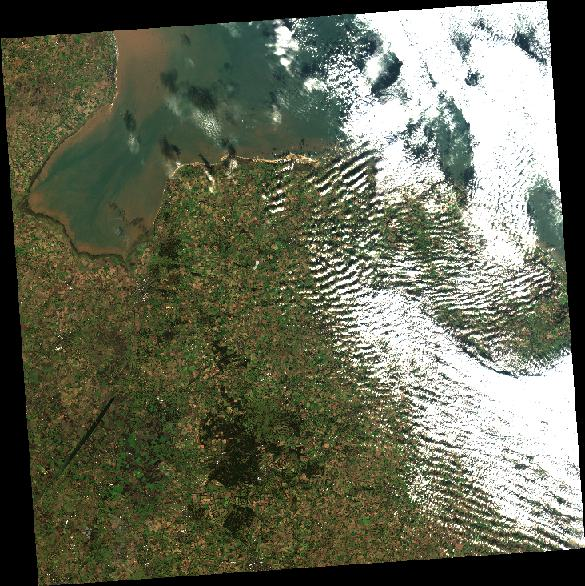

In [75]:
# We can use this information to view the image thumbnail

#asset_dict = items[1].assets

# Get the url as a string
#thumbnail_assets = [v for k, v in asset_dict.items() if 'thumbnail' in k]
#thumbnail_url = thumbnail_assets[0].href

# Here we open the remote URL, read the data and dislay the thumbnail 
with urllib.request.urlopen(tn_url) as url:
    img = Image.open(BytesIO(url.read()))

display(img)


This shows that we can relatively easily interrogate the Resource Catalogue and filter the results so that we can find the data we require in the EODH. With a bit of tweaking of the code the user could also generate a list of assets and accompanying URLs to the datasets (for this and other datasets). 

Now our user wants to see what commercial data exists for the Thetford site. 

In [78]:
# Find some commercial data

for collect in client.get_collections():
    #if 'planet' in collect.id: 
    print(f"{collect.id}: {collect.description}")

ukcp: Regional climate model projections produced as part of the UK Climate Projection 2018 (UKCP18) project. The data produced by the Met Office Hadley Centre provides information on changes in climate for the UK until 2080, downscaled to a high resolution (12km), helping to inform adaptation to a changing climate. The projections cover Europe and a 100 year period, 1981-2080, for a high emissions scenario, RCP8.5. Each projection provides an example of climate variability in a changing climate, which is consistent across climate variables at different times and spatial locations. This dataset contains 12km data for the United Kingdom, the Isle of Man and the Channel Islands provided on the Ordnance Survey's British National Grid.
sentinel2_ard: These data have been created by the Department for Environment, Food and Rural Affairs (Defra) and Joint Nature Conservation Committee (JNCC) in order to cost-effectively provide high quality, Analysis Ready Data (ARD) for a wide range of appl

In [29]:
# Let's search for information on the Planet holdings  
planet = client.get_catalog("supported-datasets/defra").get_collection('defra-planet')
planet.get_items()

lim = 5
i = 0

for item in planet.get_items():
    if i < lim:
        print(item.id)
        i += 1

print('PLANET DATASET TEMPORAL EXTENT: ', [str(d) for d in planet.extent.temporal.intervals[0]])

2024-08-23_strip_7527622_composite
2024-08-23_strip_7527462_composite
PLANET DATASET TEMPORAL EXTENT:  ['2024-08-23 11:09:19.358417+00:00', '2024-08-23 11:24:40.991786+00:00']


In [31]:
# To find specific imagery for the Thetford site we need to add the intersects parameter. We set this to be our AOI point.
items1 = client.search(
    collections=['defra-planet'],
    catalog_paths=["supported-datasets/defra"],
    intersects=thet_pnt,
    limit=10,
)

items2 = client.search(
    collections=['defra-airbus'],
    catalog_paths=["supported-datasets/defra"],
    intersects=thet_pnt,
    limit=10,
)

# We can then count the number of items returned by the search 
print('Number of Planet items found: ', items1.total_count)
print('Number of Airbus items found: ', items2.total_count)

Number of Planet items found:  1
Number of Airbus items found:  2


In [36]:
for key, value in items1[0].assets.items():
    print('Planet: ', key, value)

Planet:  data <Asset href=2024-08-23_strip_7527462_composite_file_format.tif>
Planet:  udm2 <Asset href=2024-08-23_strip_7527462_composite_udm2_file_format.tif>


The final step would be to use the ordering service integrated into the EODH resource catalogue to purchase the required commercial imagery. This would be stored in a users workspace and could then be used in specific workflows or for data analytics (depending on licence restrictions).

For the purposes of this presentation we looked at the different commercial datasets offline in QGIS. 